# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/datasets/ealaxi/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [3]:
import pandas as pd
import numpy as np

In [5]:
# Your code here
df = pd.read_csv("PS_20174392719_1491204439457_log.csv").sample(1000000)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4322754,308,CASH_IN,300104.98,C1860022258,49610.00,349714.98,C500312084,0.00,0.00,0,0
2014520,180,PAYMENT,2279.49,C489513967,45070.00,42790.51,M100076367,0.00,0.00,0,0
1464593,140,CASH_OUT,207500.36,C766669440,0.00,0.00,C2023176555,3377272.26,3567270.55,0,0
1195060,132,TRANSFER,561898.95,C1047514788,540585.00,0.00,C2129305383,78744.41,640643.36,0,0
2181325,185,PAYMENT,1825.79,C953842295,148853.03,147027.24,M1794173888,0.00,0.00,0,0


In [7]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [9]:
df.corr()

C:\Users\jmpcs\AppData\Local\Temp\ipykernel_21428\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022195,-0.010006,-0.010303,0.028883,0.027078,0.032551,0.001617
amount,0.022195,1.000000,-0.002772,-0.007899,0.292567,0.455528,0.079009,0.016886
oldbalanceOrg,-0.010006,-0.002772,1.000000,0.998809,0.066670,0.042737,0.009661,0.005578
newbalanceOrig,-0.010303,-0.007899,0.998809,1.000000,0.068156,0.042505,-0.008695,0.005499
oldbalanceDest,0.028883,0.292567,0.066670,0.068156,1.000000,0.977110,-0.005703,-0.000455
newbalanceDest,0.027078,0.455528,0.042737,0.042505,0.977110,1.000000,0.000739,-0.000470
isFraud,0.032551,0.079009,0.009661,-0.008695,-0.005703,0.000739,1.000000,0.039674
isFlaggedFraud,0.001617,0.016886,0.005578,0.005499,-0.000455,-0.000470,0.039674,1.000000


### What is the distribution of the outcome? 

<AxesSubplot: >

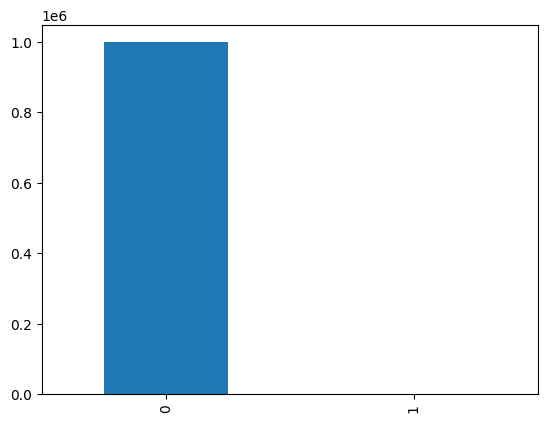

In [10]:
# Your response here
pd.value_counts(df['isFraud']).plot(kind = 'bar')

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

<AxesSubplot: >

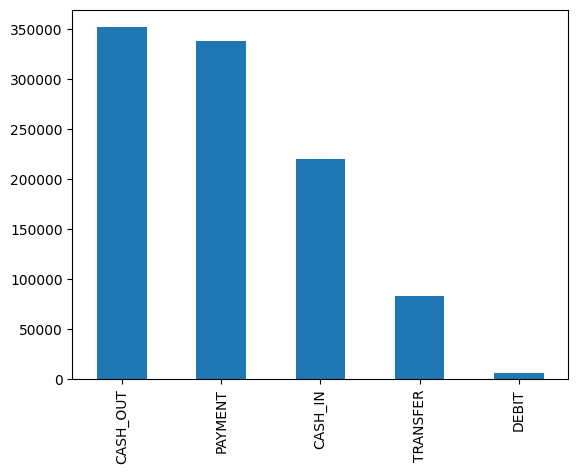

In [11]:
# Your code here
pd.value_counts(df['type']).plot(kind = 'bar')

In [12]:
df = pd.get_dummies(df, columns=['type'])
df.drop(['nameOrig','nameDest'], axis = 1, inplace=True)
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
4322754,308,300104.98,49610.00,349714.98,0.00,0.00,0,0,1,0,0,0,0
2014520,180,2279.49,45070.00,42790.51,0.00,0.00,0,0,0,0,0,1,0
1464593,140,207500.36,0.00,0.00,3377272.26,3567270.55,0,0,0,1,0,0,0
1195060,132,561898.95,540585.00,0.00,78744.41,640643.36,0,0,0,0,0,0,1
2181325,185,1825.79,148853.03,147027.24,0.00,0.00,0,0,0,0,0,1,0


### Run a logisitc regression classifier and evaluate its accuracy.

In [14]:
# Your code here
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

data = df.drop(labels='isFraud', axis=1)
target = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size= 0.2)

LR = LogisticRegression()
LR.fit(X_train,y_train)
LR.score(X_test,y_test)
pred = LR.predict(X_test)

LR.score(X_train,y_train)

0.99852

In [15]:
pred = LR.predict(X_test)
confusion_matrix(y_test, pred)

array([[199578,    175],
       [   149,     98]], dtype=int64)

### Now pick a model of your choice and evaluate its accuracy.

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier(n_estimators = 1000
                                ,learning_rate = 1
                                ,max_depth = 1
                                ,random_state = 0).fit(X_train, y_train)

display(clf.score(X_train,y_train))

display(accuracy_score(y_train, clf.predict(X_train)))
display(accuracy_score(y_test, clf.predict(X_test)))

display(confusion_matrix(y_test, clf.predict(X_test)))

KeyboardInterrupt: 

### Which model worked better and how do you know?

In [ ]:
#Regression Model worked better, LogisticRegression

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.